# Classification

In this notebook we are going to see the 2 approaches that are possible for classification:
- **Discriminant function approach**:
  + model a *function* that maps inputs to classes
  + fit model to data
- **Probabilistic discriminative approach**:
  + model a *conditional probability* $P(C_k | x)$
  + fit model to data

We are going to use the same dataset used in the second notebook and created in the first one.

In [132]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [133]:
np.random.seed(42)

In [134]:
data_path = 'data'

In [135]:
station_df = pd.read_excel(os.path.join(data_path, 'clean_data.xlsx'), index_col=0)

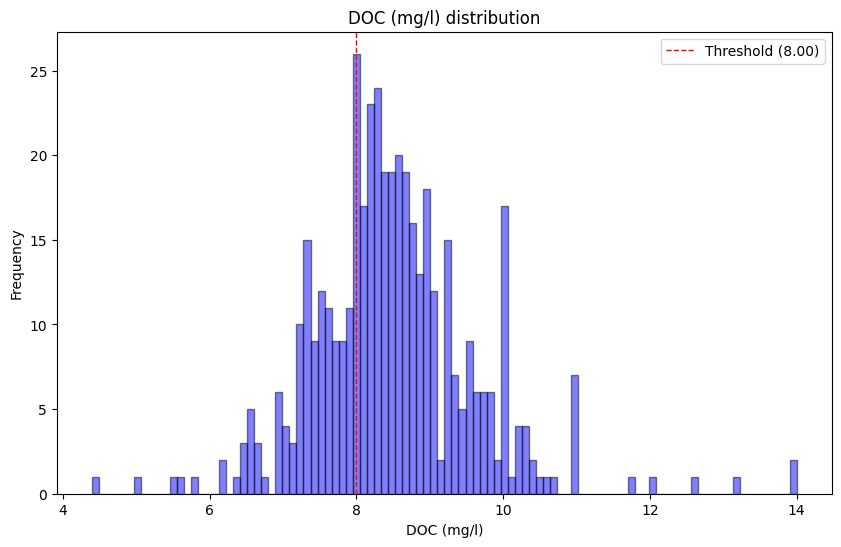

In [136]:
# Since no class is given, we are going to define custom ones on the target variable (DOC (mg/l))
# using a custom value as threshold
threshold = 8.0

plt.figure(figsize=(10, 6))

plt.hist(station_df['DOC (mg/l)'], bins=100, alpha=0.5, color='b', edgecolor='black')

plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f"Threshold ({threshold:.2f})")

plt.xlabel('DOC (mg/l)')
plt.ylabel('Frequency')

plt.title('DOC (mg/l) distribution')
plt.legend()

plt.show()

In [137]:
# We are going to create a new column with the class labels
station_df['DOC_class'] = np.where(station_df['DOC (mg/l)'] > threshold, 1, 0)

In [138]:
X = station_df.drop(columns=['DOC (mg/l)', 'DOC_class']).copy()
y = station_df['DOC_class'].copy()

In [139]:
# scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

## Discriminant Function Approach

### Perceptron

At first, let us perform a classification with a perceptron classifier:
- Hypothesis space: $y(\mathbf{x}_n) = sgn(\mathbf{w}^T \mathbf{x}_n) = sgn(w_0 + x_{n1} w_1 + x_{n2} w_2)$;
- Loss measure: Distance of misclassified points from the separating surface $L_P(\mathbf{w}) = -\sum_{n \in \mathcal{M}} \mathbf{w}^T \mathbf{x}_n C_n$;
- Optimization method: Online Gradient Descent;

where $sgn(\cdot)$ is the sign function.

In [140]:
from sklearn.linear_model import Perceptron
perc_classifier = Perceptron(shuffle=False)
perc_classifier.fit(X_scaled, y)

Perceptron(shuffle=False)

In [141]:
y_pred = perc_classifier.predict(X_scaled)

station_df['DOC_class_pred'] = y_pred

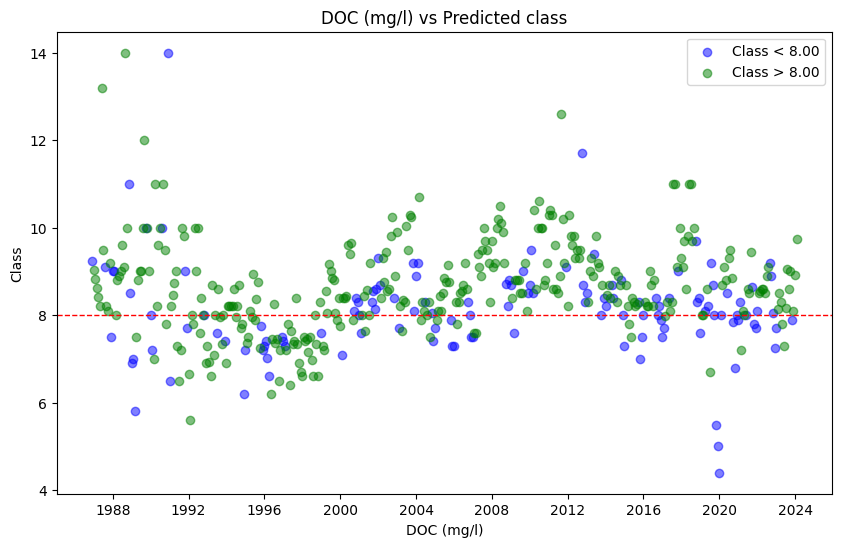

In [142]:
# We are going to plot the DOC (mg/l) values and the predicted classes

plt.figure(figsize=(10, 6))

plt.scatter(
    station_df[station_df['DOC_class_pred'] == 0].index,
    station_df[station_df['DOC_class_pred'] == 0]['DOC (mg/l)'],
    color='b',
    label=f"Class < {threshold:.2f}",
    alpha=0.5
)

plt.scatter(
    station_df[station_df['DOC_class_pred'] == 1].index,
    station_df[station_df['DOC_class_pred'] == 1]['DOC (mg/l)'],
    color='g',
    label=f"Class > {threshold:.2f}",
    alpha=0.5
)

plt.axhline(threshold, color='r', linestyle='dashed', linewidth=1)

plt.xlabel('DOC (mg/l)')
plt.ylabel('Class')

plt.title('DOC (mg/l) vs Predicted class')
plt.legend()

plt.show()

To evaluate the performances of the chosen method, we need to compute the *confusion matrix* which tells us the number of points which have been correctly classified and those which have been misclassified.

 <table style="width:100%">
  <tr>
    <th>
    <center> <img src='https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg' width=300 /> </center>
    </th>
    <th>
</th>
  </tr>

</table>




Based on this matrix we can evaluate:
- Accuracy: $Acc = \frac{tp + tn}{N}$ fraction of the samples correctly classified in the dataset;
- Precision $Pre = \frac{tp}{tp + fp}$ fraction of samples correctly classified in the positive class among the ones classified in the positive class;
- Recall: $Rec = \frac{tp}{tp + fn}$ fraction of samples correctly classified in the positive class among the ones belonging to the positive class;
- F1 score: $F1 = \frac{2 \cdot Pre \cdot Rec}{Pre + Rec}$ harmonic mean of the precision and recall;

where $tn$ is the number of true negatives, $fp$ is the number of false positives, $fn$ are the false negatives and $tn$ are the true negatives.
Equivalently, we can look at the meaning of Precision and Recall by looking at the figure above.

Remember that:
- The higher these figures of merits the better the algorithm is performing.
- These performance measures are **not** symmetric, but depends on the class we selected as positive.
- Depending on the **application** one might switch the classes to have measures which better evaluate the predictive power of the classifier.

In [143]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

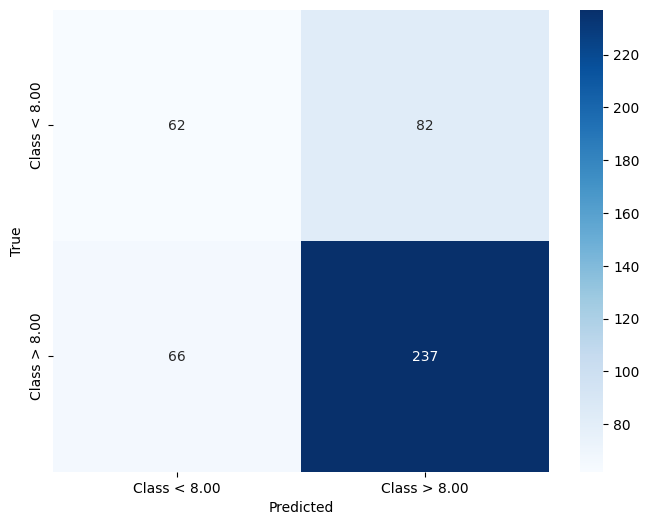

In [144]:
conf_matrix = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"Class < {threshold:.2f}", f"Class > {threshold:.2f}"],
    yticklabels=[f"Class < {threshold:.2f}", f"Class > {threshold:.2f}"]
)

plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

In [145]:
accuracy_score(y, y_pred)

0.668903803131991

In [146]:
precision_score(y, y_pred)

np.float64(0.7429467084639498)

In [147]:
recall_score(y, y_pred)

np.float64(0.7821782178217822)

In [148]:
f1_score(y, y_pred)

np.float64(0.7620578778135049)

### Support Vector Machine

While Perceptron tries to find the decision boundary directly in the input space, SVM finds the optimal hyperplane that maximally separates different classes by mapping the data from the input space to a higher-dimensional space (through the [Kernel Trick](https://en.wikipedia.org/wiki/Kernel_method)), where a linear decision boundary can be found. It is able to capture non-linearities in the data.

We are going to compare the linear and the RBF kernels.

In [149]:
from sklearn import svm

In [150]:
lin_kernel_svm = svm.SVC(kernel='linear') # no mapping to higher dimension
rbf_kernel_svm = svm.SVC(kernel='rbf')

In [151]:
lin_kernel_svm.fit(X_scaled, y)
rbf_kernel_svm.fit(X_scaled, y)

SVC()

In [152]:
y_pred_lin = lin_kernel_svm.predict(X_scaled)
y_pred_rbf = rbf_kernel_svm.predict(X_scaled)

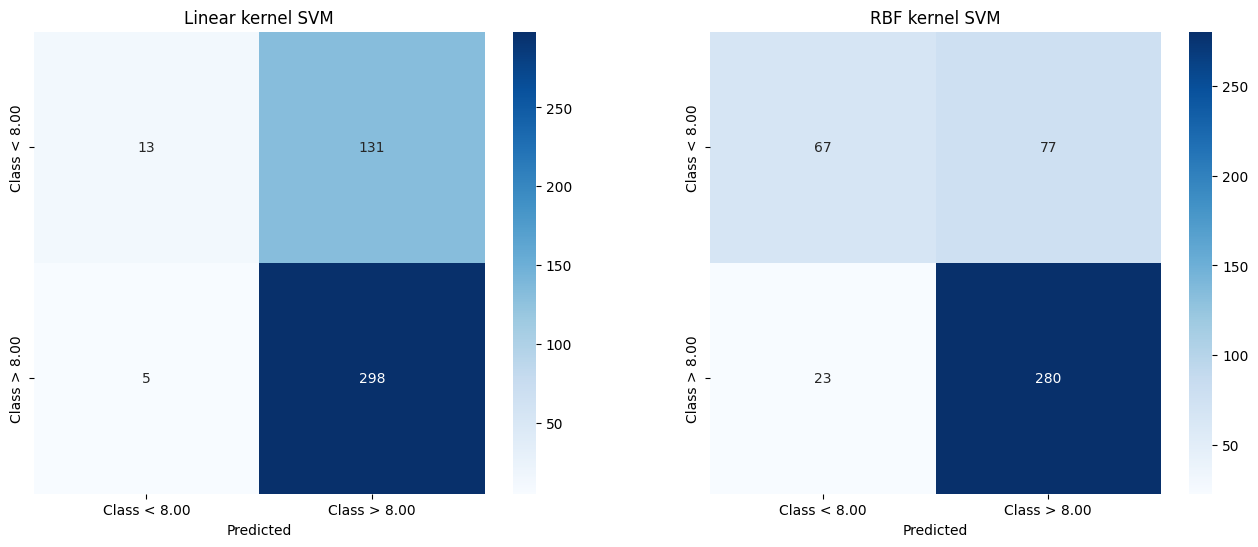

In [153]:
# compare the results
conf_matrix_lin = confusion_matrix(y, y_pred_lin)
conf_matrix_rbf = confusion_matrix(y, y_pred_rbf)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    conf_matrix_lin,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"Class < {threshold:.2f}", f"Class > {threshold:.2f}"],
    yticklabels=[f"Class < {threshold:.2f}", f"Class > {threshold:.2f}"],
    ax=ax[0]
)

ax[0].set_title('Linear kernel SVM')
ax[0].set_xlabel('Predicted')

sns.heatmap(
    conf_matrix_rbf,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"Class < {threshold:.2f}", f"Class > {threshold:.2f}"],
    yticklabels=[f"Class < {threshold:.2f}", f"Class > {threshold:.2f}"],
    ax=ax[1]
)

ax[1].set_title('RBF kernel SVM')
ax[1].set_xlabel('Predicted')

plt.show()

In [154]:
print(f"Linear kernel SVM accuracy: {accuracy_score(y, y_pred_lin)}")
print(f"RBF kernel SVM accuracy: {accuracy_score(y, y_pred_rbf)}")

Linear kernel SVM accuracy: 0.6957494407158836
RBF kernel SVM accuracy: 0.7762863534675615


In [155]:
print(f"Linear kernel SVM precision: {precision_score(y, y_pred_lin)}")
print(f"RBF kernel SVM precision: {precision_score(y, y_pred_rbf)}")

Linear kernel SVM precision: 0.6946386946386947
RBF kernel SVM precision: 0.7843137254901961


In [156]:
print(f"Linear kernel SVM recall: {recall_score(y, y_pred_lin)}")
print(f"RBF kernel SVM recall: {recall_score(y, y_pred_rbf)}")

Linear kernel SVM recall: 0.9834983498349835
RBF kernel SVM recall: 0.9240924092409241


In [158]:
print(f"Linear kernel SVM F1 score: {f1_score(y, y_pred_lin)}")
print(f"RBF kernel SVM F1 score: {f1_score(y, y_pred_rbf)}")

Linear kernel SVM F1 score: 0.8142076502732241
RBF kernel SVM F1 score: 0.8484848484848485


## Probabilistic Discriminative Approach: Logistic Regression

Let us change the methods for the classification task and use a Logistic regression classifier with two classes:
- Hypothesis space: $y_n = y(x_n) = \sigma(w_0 + x_{n1} w_1 + x_{n2} w_2)$;
- Loss measure: Loglikelihood $L(\mathbf{w}) = -\sum_{n=1}^N  [C_n \ln y_n + (1 - C_n) \ln (1 - y_n)]$;
- Optimization method: Gradient Descent;

where the sigmoid function is defined as $\sigma(x) = \frac{1}{1 + e^{-x}}$.

In [119]:
from sklearn.linear_model import LogisticRegression

log_classifier = LogisticRegression(penalty=None) # default is penalty='l2', that is l2 regularization
log_classifier.fit(X_scaled, y)

LogisticRegression(penalty=None)

In [120]:
y_pred = log_classifier.predict(X_scaled)

station_df['DOC_class_pred'] = y_pred

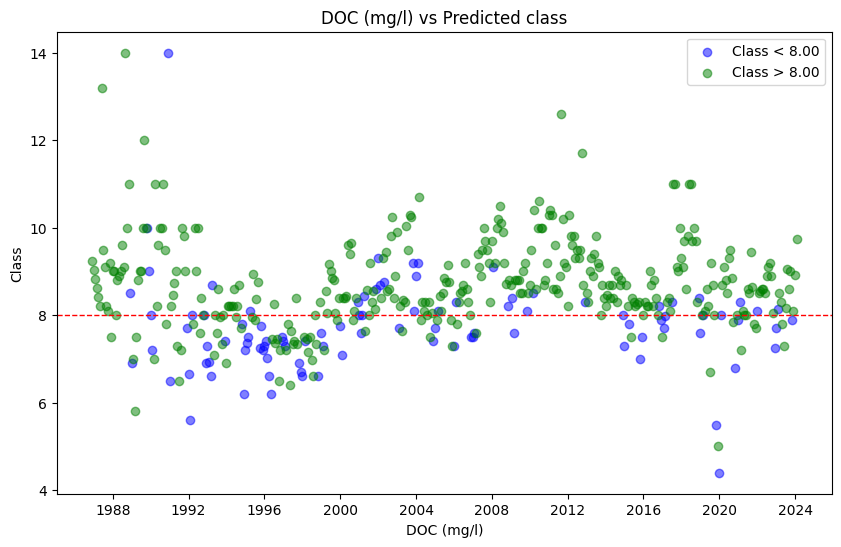

In [121]:
# We are going to plot the DOC (mg/l) values and the predicted classes

plt.figure(figsize=(10, 6))

plt.scatter(
    station_df[station_df['DOC_class_pred'] == 0].index,
    station_df[station_df['DOC_class_pred'] == 0]['DOC (mg/l)'],
    color='b',
    label=f"Class < {threshold:.2f}",
    alpha=0.5
)

plt.scatter(
    station_df[station_df['DOC_class_pred'] == 1].index,
    station_df[station_df['DOC_class_pred'] == 1]['DOC (mg/l)'],
    color='g',
    label=f"Class > {threshold:.2f}",
    alpha=0.5
)

plt.axhline(threshold, color='r', linestyle='dashed', linewidth=1)

plt.xlabel('DOC (mg/l)')
plt.ylabel('Class')

plt.title('DOC (mg/l) vs Predicted class')
plt.legend()

plt.show()

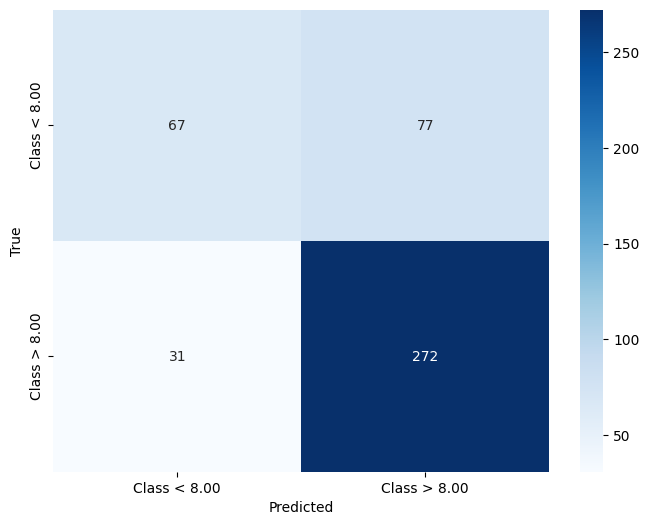

In [122]:
conf_matrix = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"Class < {threshold:.2f}", f"Class > {threshold:.2f}"],
    yticklabels=[f"Class < {threshold:.2f}", f"Class > {threshold:.2f}"]
)

plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

In [123]:
accuracy_score(y, y_pred)

0.7583892617449665

In [124]:
precision_score(y, y_pred)

np.float64(0.7793696275071633)

In [125]:
recall_score(y, y_pred)

np.float64(0.8976897689768977)

In [126]:
f1_score(y, y_pred)

np.float64(0.8343558282208589)